In [21]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from pathlib import Path
import jax.numpy as jnp
import math 

In [23]:
logs_base_path = "../../logs/"

experiment_names = ["div-alternate-trained", "div_mse-alternate-trained", "s5-alternate-trained", "mnist-alternate-trained"]

min_dots = math.inf 
max_dots = -math.inf 

for experiment_name in experiment_names:
  checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

  with open(checkpoint_dir, "r") as json_file:
    df = pd.read_json(json_file)

  max_dots = max(max_dots, max(df["dots"]))
  min_dots = min(min_dots, min(df["dots"]))

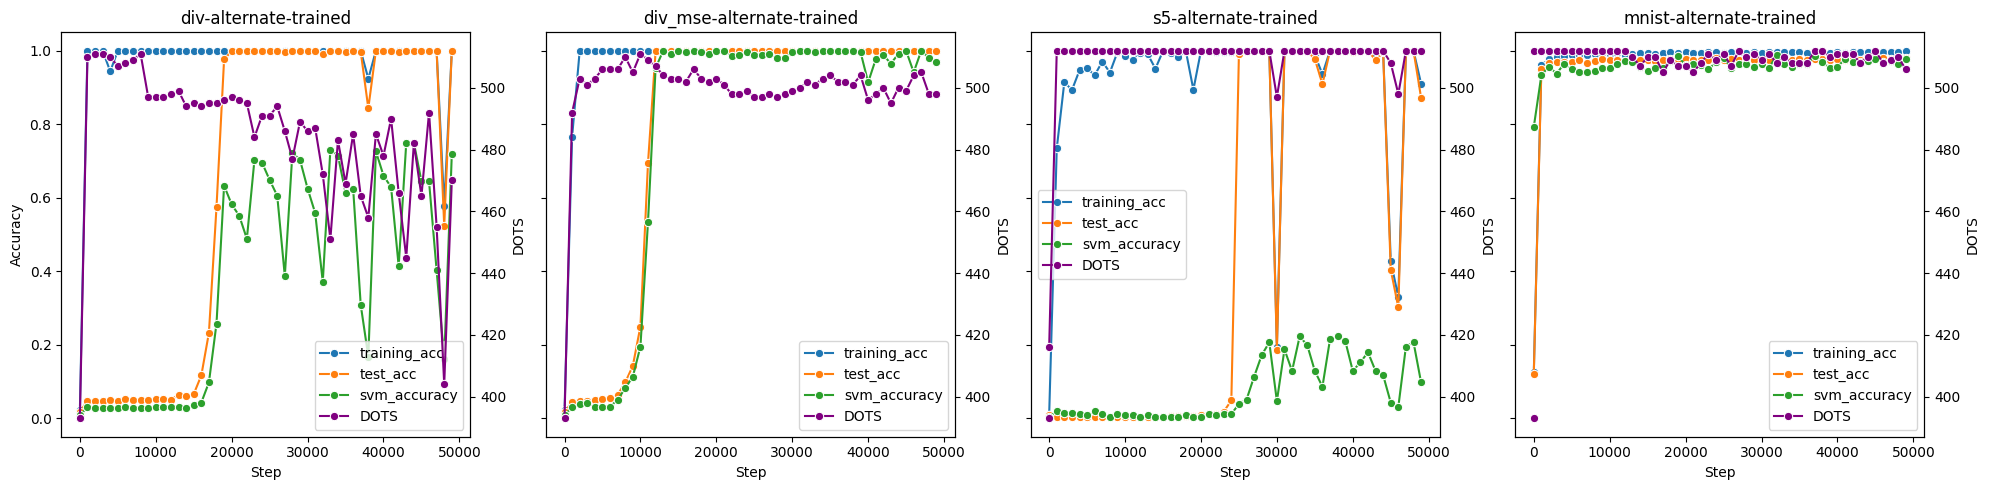

In [35]:
logs_base_path = "../../logs/"
experiment_names = ["div-alternate-trained", "div_mse-alternate-trained", "s5-alternate-trained", "mnist-alternate-trained"]
num_experiments = len(experiment_names)

fig, axs = plt.subplots(1, num_experiments, figsize=(num_experiments * 5, 5), sharey=True)

for i, experiment_name in enumerate(experiment_names):
    
    checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

    with open(checkpoint_dir, "r") as json_file:
        df = pd.read_json(json_file)

    df["step"] = df.index * 1000
    df1 = df[["step", "training_acc", "test_acc", "svm_accuracy"]]
    df1 = df1.melt("step", var_name="type", value_name="Accuracy")

    df2 = df[["step", "dots"]]
    df2 = df2.melt("step", var_name="dots", value_name="DOTS")

    ax1 = axs[i]
    ax2 = ax1.twinx()

    sns.lineplot(data=df1, x="step", y="Accuracy", hue="type", marker="o", ax=ax1)
    ax1.set(title=experiment_name, xlabel="Step", ylabel="Accuracy")
    ax1.set_ylim([-0.05, 1.05])

    # Dummy item for legend 
    sns.lineplot([0], label="DOTS", marker="o", color="purple", ax=ax1)

    sns.lineplot(data=df2, x="step", y="DOTS", marker="o", color="purple", ax=ax2)
    visual_buffer = (max_dots - min_dots) * 0.05
    ax2.set_ylim([min_dots - visual_buffer, max_dots + visual_buffer])

fig.tight_layout()

In [10]:
s5_checkpoint_dir = Path(logs_base_path, "results", "s5.json")

with open(checkpoint_dir, "r") as json_file:
  df = pd.read_json(json_file)

print(jnp.array(df["kernel"][0]))

[[1276.2465   790.6056   639.2642   544.5854   754.1954 ]
 [ 790.6056  1231.8292   771.30634  738.88434  860.0592 ]
 [ 639.2642   771.30634 1130.0719   843.1396   817.7565 ]
 [ 544.5854   738.88434  843.1396  1214.6346   690.7385 ]
 [ 754.1954   860.0592   817.75653  690.7385  1286.2899 ]]


2024-02-22 12:00:29.141733: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
